A notebook to cost a single Trotter step of the 1D Holstein model (see [Sec II.3 here](https://arxiv.org/pdf/2307.06580)) using an all qubit architecture. 

In [22]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util

import qutip as qt

The one-dimensional version of the Holstein model reads

$$
\hat{H} = - \sum_{\langle i, j \rangle} V f^\dagger_i f_j + \sum_i \omega b^\dagger_i b_i + \sum_i g \omega f^\dagger_i f_i (b^\dagger_i + b_i).
$$
A two-site Holstein model with periodic boundary conditions:
$$
\begin{aligned}
\hat{H} &= -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) \\
&\quad + \omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) + f^\dagger_2 f_2 \left( b^\dagger_2 + b_2 \right) \Bigr].
\end{aligned}
$$.

For each site you require one qubit for the fermion and $\log_2(n_{\text{max}}+1)$ qubits for the bosonic mode (with cutoff $n_{\text{max}}$). Thus, for $N$ sites the total number of qubits is
$$
N(1+\log_2(n_{max} + 1)).
$$

In [23]:
def holstein_hamiltonian(v=1.0, omega=1.0, g=1.0, N_b=7):
    
    N_b = N_b + 1 #cutoff + 1 is hilbert space total dims
    
    I_f = qt.qeye(2)
    
    # Define the lowering operator for fermions
    f1 = qt.tensor(qt.destroy(2), I_f)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    
    # Each bosonic mode is truncated to N_b
    I_b = qt.qeye(N_b)
    
    # [fermion, fermion, mode 1, mode 2]
    f1_tot = qt.tensor(f1, I_b, I_b)  
    f2_tot = qt.tensor(f2, I_b, I_b)  
    
    # Number operators for the fermions
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    # bosons
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    # Now embed into the full Hilbert space
    b1_tot = qt.tensor(I_f, I_f, b1, I_b)  # mode 1
    b1_dag_tot = b1_tot.dag()
    b2_tot = qt.tensor(I_f, I_f, I_b, b2)  # mode 2
    b2_dag_tot = b2_tot.dag()
    
    H_hop = -v * (f1_tot.dag() * f2_tot + f2_tot.dag() * f1_tot) # Hopping term
    H_phonon = omega * (b1_dag_tot * b1_tot + b2_dag_tot * b2_tot) # Boson "on-site potential"
    H_int = g * omega * (n1_tot * (b1_tot + b1_dag_tot) + n2_tot * (b2_tot + b2_dag_tot)) #fermion boson coupling
    H_total = H_hop + H_phonon + H_int

    return H_total

def define_initial_state(n_max, num_modes=2, ferm_qubits=2):
    """
    Define the initial state vector for the system with preset 2 modes and 2 qubits for the fermions.
    """
    
    qubits_per_mode = int(np.ceil(np.log2(n_max + 1))) # qubis for each mode (fock-binary encoding)
    total_qubits = num_modes * qubits_per_mode + ferm_qubits 
    initial_state_vector = np.zeros(2**total_qubits, dtype=complex)
    initial_state_vector[0] = 1.0 #arbitrary iinital state

    return Statevector(initial_state_vector)

In [24]:
def get_trotter_circuit(H, dt, num_timesteps, initial_state, order=1):
    """
    Applies Trotter evolution to the initial_state using the specified order
    and number of timesteps, and returns the resulting circuit.
    """
    if order == 1:
        synthesis_method = LieTrotter()
    elif order == 2:
        synthesis_method = SuzukiTrotter()  # `SuzukiTrotter()` defaults to 2nd order
    elif order == 4:
        synthesis_method = SuzukiTrotter(order=4)
    elif order == 6:
        synthesis_method = SuzukiTrotter(order=6)
    else:
        raise ValueError(f"Unsupported Trotter order: {order}. Supported orders: 1, 2, 4, 6.")
    
    trotter_gate = PauliEvolutionGate(H, dt, synthesis=synthesis_method)
    circuit = QuantumCircuit(H.num_qubits)
    
    # Initialize the circuit with the initial_state
    circuit.initialize(initial_state.data, range(H.num_qubits))
    
    # Append the Trotter evolution gate repeatedly for the number of timesteps
    for _ in range(num_timesteps):
        circuit.append(trotter_gate, range(H.num_qubits))
    
    return circuit

We note that exponentiating a Pauli string requires a single non-clifford gate (the CNOT staircase method, see [fig 3 here](https://arxiv.org/pdf/1909.12847)), so therefore the number of non-Clifford gates will be equal to the number of terms in the Pauli string. We use qiskits `SparsePauliOp` (in a similar spirit to the method in [1909.12847](https://arxiv.org/pdf/1909.12847)) to do this..

In [25]:
qubit_counts = range(1, 7)  
cutoff_values = [2**q - 1 for q in qubit_counts]  # cutoffs

analytical_nonclifford_counts_1 = []
analytical_total_qubits = []
total_qubit_counts = []
nonclifford_counts = []

# modes and qubits for total counts plot
num_modes = 2      
ferm_qubits = 2   

for cutoff in cutoff_values:
    hamiltonian_matrix = holstein_hamiltonian(N_b=cutoff).full()
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix)) # convert to sum of pauli strings
    
    terms = H.to_list() # terms as a list of tuples: (pauli_string, coefficient)
    
    # Non-Clifford counts is just no. terms
    nonclifford_count = len(terms)
    nonclifford_counts.append(nonclifford_count)
    
    # total qubits required for this cutoff 
    qubits_per_mode = int(np.ceil(np.log2(cutoff + 1)))
    total_qubits = 2 * qubits_per_mode + 2 #2 sites so 2 modes and 2 qubits
    total_qubit_counts.append(total_qubits)

header = (
    f"{'q':3} | {'Cutoff':6} || "
    f"{'Non-Cliffs':11} | "
    f"{'Total Qubits':13}| "
    f"{'2^(q+1)q+2q+3'}"
)
print(header)
print("-" * len(header))

for q, cutoff, non_cliff, tot_qubits in zip(
    qubit_counts,
    cutoff_values,
    nonclifford_counts,
    total_qubit_counts,
):
    print(
        f"{q:3} | {cutoff:6} | "
        f"{non_cliff:11} | "
        f"{tot_qubits:13} | "
        f"{2**(q+1)*q + 2*q + 3}" #actual
    )

q   | Cutoff || Non-Cliffs  | Total Qubits | 2^(q+1)q+2q+3
----------------------------------------------------------
  1 |      1 |           9 |             4 | 9
  2 |      3 |          23 |             6 | 23
  3 |      7 |          57 |             8 | 57
  4 |     15 |         139 |            10 | 139
  5 |     31 |         333 |            12 | 333
  6 |     63 |         783 |            14 | 783


### Generalising for $N$ sties
Above, we saw an exponential scaling for the number of non-clifford operators in terms of the boson cutoff for a fixed $N = 2$ sites. We can now create a general Hamiltonian for $N$ sites and do the same procedure to verify how the the number of non-cliffords scales with the number of sites.

In [26]:
def onsite_boson_term(n_sites = 2, omega = 1, N_b = 7):
    """
    Constructs the onsite boson term
    """
    d_b = N_b + 1 #cutoff + 1

    b = qt.destroy(d_b)   # annihilation operator 
    number_op = b.dag() * b   # number operator
    I = qt.qeye(d_b)             

    # Initialize the total term
    H_boson = 0

    for i in range(n_sites):
        # list of operators where the i-th entry is the number operator,
        # and all other entries are the identity.
        op_list = [number_op if j == i else I for j in range(n_sites)]
        H_i = qt.tensor(*op_list)
        H_boson += H_i

    H_boson = omega * H_boson

    return H_boson


def interaction_term(n_sites = 2, omega = 1, g = 1, N_b= 7):
    """
    """
    d_f = 2            # two-level system per site (empty/occupied)
    d_b = N_b + 1      # bosonic cutoff + 1
    I_f = qt.qeye(d_f)
    I_b = qt.qeye(d_b)

    # Fermionic number operator: n = |1><1|
    n_local = qt.Qobj([[0, 0],
                       [0, 1]])
    
    # Bosonic operators for single mode
    b = qt.destroy(d_b)
    b_dag = b.dag()
    disp_b = b + b_dag  

    # Initialize the total term
    H_total = 0
    
    for i in range(n_sites):
        fermion_op_list = [I_f for _ in range(n_sites)]
        fermion_op_list[i] = n_local
        H_f_i = qt.tensor(*fermion_op_list)
        
        # Build the bosonic displacement operator for site i
        boson_disp_list = [I_b for _ in range(n_sites)]
        boson_disp_list[i] = disp_b
        H_disp_i = qt.tensor(*boson_disp_list)
        
        H_int_i = g * omega * qt.tensor(H_f_i, H_disp_i)
        
        # Add this site's contribution
        H_total += H_int_i
        
    return H_total

def fermionic_hopping_term(n_sites = 2, V = 7):
    """
    Constructs the fermionic hopping term:
    """
    I = qt.qeye(2)
    sigmaz = qt.sigmaz()

    fermion_ops = []
    for i in range(n_sites):
        op_list = []
        for j in range(n_sites):
            if j < i:
                op_list.append(sigmaz)      # Jordan-Wigner string
            elif j == i:
                op_list.append(qt.destroy(2))  # Local annihilation operator
            else:
                op_list.append(I)
        f_i = qt.tensor(*op_list)
        fermion_ops.append(f_i)

    # Now sum the nearest-neighbor hopping terms with periodic boundary conditions
    H_hop = 0
    for i in range(n_sites):
        j = (i + 1) % n_sites
        H_hop += -V * (fermion_ops[i].dag() * fermion_ops[j] + fermion_ops[j].dag() * fermion_ops[i])
    
    return H_hop

In [30]:
def build_full_hamiltonian(n_sites=2, N_b=7, omega=1, g=1, V=7):
    """
    Constructs the full Hamiltonian for a system with n_sites fermionic and bosonic sites.

    """
    # Generate the individual Hamiltonian terms with n_sites
    int_term   = interaction_term(n_sites=n_sites, omega=omega, g=g, N_b=N_b)
    hop_term   = fermionic_hopping_term(n_sites=n_sites, V=V)
    onsite_term = onsite_boson_term(n_sites=n_sites, omega=omega, N_b=N_b)
    
    # Embed the fermionic hopping term into the full Hilbert space.
    boson_identities = [qt.qeye(N_b+1) for _ in range(n_sites)]
    full_hop = qt.tensor(hop_term, *boson_identities)
    
    # Embed the onsite boson term into the full Hilbert space.
    fermion_identities = [qt.qeye(2) for _ in range(n_sites)]
    full_onsite = qt.tensor(*fermion_identities, onsite_term)
    
    # full Hamiltonian
    H_full = full_hop + full_onsite + int_term

    return H_full

In [31]:
print("n_sites  | q |  non clifford terms")
print("-------------------------------")
for q in [1, 2]:
    N_b = 2**q - 1
    for n in range(2, 5):
        # Build Hamiltonian 
        H = build_full_hamiltonian(n_sites=n, N_b=N_b)
        H_sparse = SparsePauliOp.from_operator(Operator(H.full()))
        non_clifford = len(H_sparse.to_list())
        print(f"{n:8d}  | { n*(q*2**(q) + q + 2) + 1 }   |     {non_clifford}")


n_sites  | q |  non clifford terms
-------------------------------
       2  | 11   |     9
       3  | 16   |     16
       4  | 21   |     21
       2  | 25   |     23
       3  | 37   |     37


       4  | 49   |     49


We find, for a single Trotter step, for $N>2$ sites and a cutoff $K = 2^q -1$, the number of non-cliffords scales as $N(q2^q+q+2)+1.$ The scaling is less for $N = 2$ ($N(q2^q+q+2)-1$) due to one less hopping term due to the periodic boundary conditions.


Below, we can now make some plots and compare to the hybrid implementation (done [here](https://github.com/samgodwood/bosonic-qiskit/blob/main/playground/bosonic_operator_costs/holstein/hybrid_holstein.ipynb)). At this point, a couple of things to note: "qubit counts" for the hybrid architecture are half oscillators, half qubits. "gate counts" for all qubit architecture are non-cliffords, while for the hybrid they are total (uncompiled) gates.

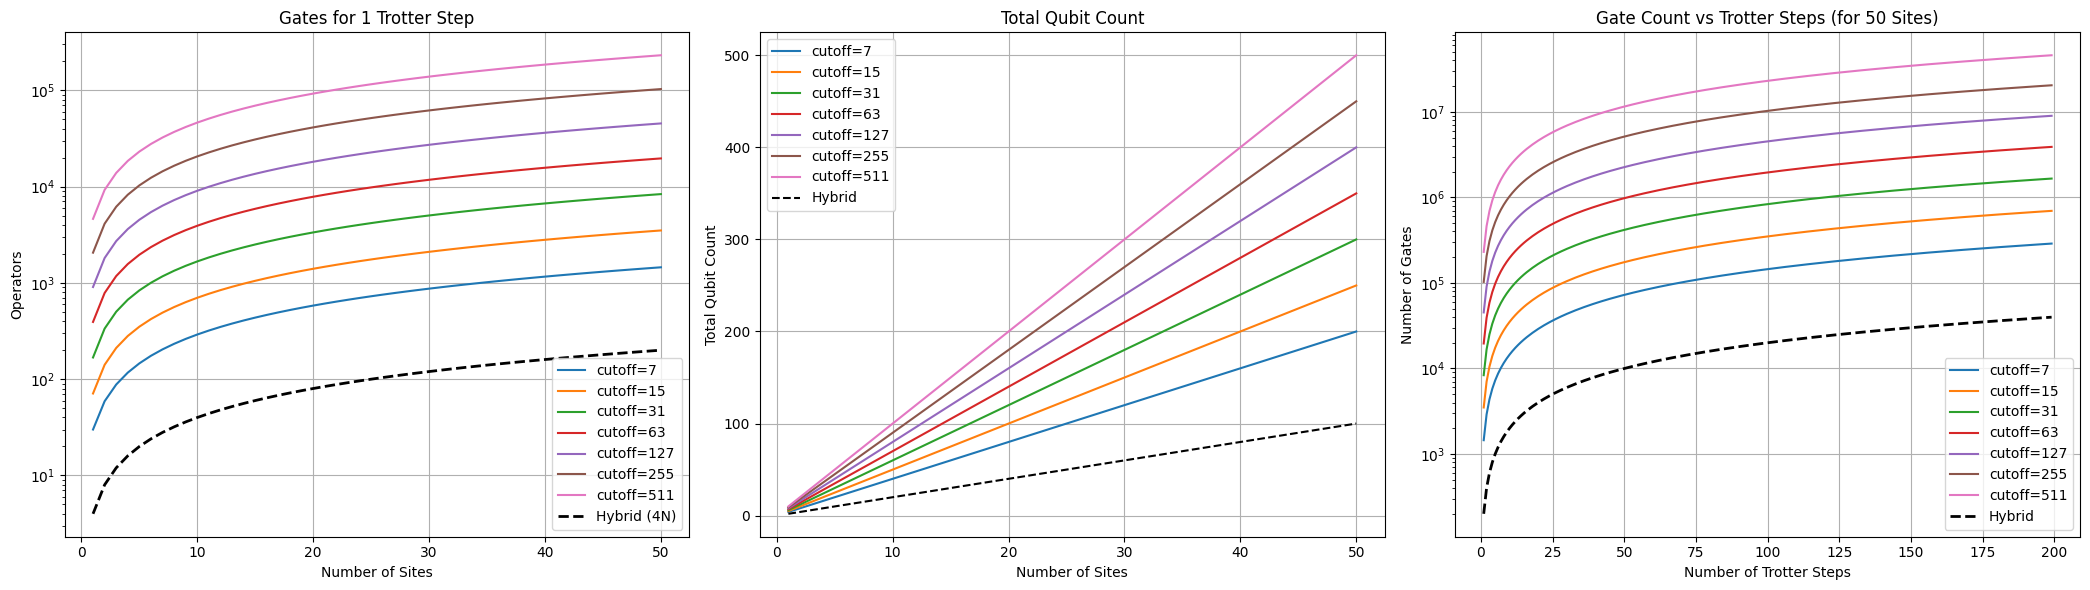

In [29]:
# First two plots parameters
q_values = np.arange(3, 10)
cutoffs = 2 ** q_values - 1
N = np.arange(1, 51)

# Third plot parameters
fixed_sites = 50
trotter_steps = np.arange(1, 200)

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# --- First subplot: All-Qubit vs. Hybrid Operators ---
for q, cutoff in zip(q_values, cutoffs):
    axes[0].plot(N, N * (q * (2 ** q) + q + 2) + 1,
                 label=f'cutoff={cutoff}')
axes[0].plot(N, 4 * N, 'k--', linewidth=2, label='Hybrid (4N)')
axes[0].set(xlabel="Number of Sites", ylabel="Operators", yscale="log",
            title="Gates for 1 Trotter Step")
axes[0].grid(True)
axes[0].legend()

# --- Second subplot: Total Qubit Count: Hybrid vs. All-Qubit ---
for q, cutoff in zip(q_values, cutoffs):
    axes[1].plot(N, N * (1 + np.log2(cutoff + 1)),
                 label=f'cutoff={cutoff}')
axes[1].plot(N, 2 * N, 'k--', label='Hybrid')
axes[1].set(xlabel="Number of Sites", ylabel="Total Qubit Count",
            title="Total Qubit Count")
axes[1].grid(True)
axes[1].legend()

# --- Third subplot: Gate Count vs. Trotter Steps (for 50 Sites) ---
for q, cutoff in zip(q_values, cutoffs):
    single_step_gates = fixed_sites * (q * (2 ** q) + q + 2) + 1
    total_gates = trotter_steps * single_step_gates
    axes[2].plot(trotter_steps, total_gates, label=f'cutoff={cutoff}')

hybrid_gate_per_step = 4 * fixed_sites  
axes[2].plot(trotter_steps, trotter_steps * hybrid_gate_per_step, 'k--', linewidth=2, label='Hybrid')
axes[2].set(xlabel="Number of Trotter Steps", ylabel="Number of Gates", yscale="log",
            title=f"Gate Count vs Trotter Steps (for {fixed_sites} Sites)")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()